# BANKING: DIRECT MARKETING CASE STUDY (CAMPAIGN RESPONSE MODEL) - CLASSIFICATION MODEL
OBJECTIVE: This Business problem uses data related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to assess if the product (bank term deposit) would be subscribed ('yes') or not ('no').


Data Source: https://archive.ics.uci.edu/ml/datasets/Bank+Marketing

### Import Packages

In [120]:
#Packages related to general operating system & warnings 
import warnings
warnings.filterwarnings('ignore')

#Packages related to data importing, manipulation, exploratory data analysis, data understanding
import numpy as np
import pandas as pd
import pandas_profiling
import scipy.stats as stats

#Packages related to data visualizaiton
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


#Modules related to split the data & gridsearch
from sklearn.model_selection import train_test_split, GridSearchCV

#Module related to calculation of metrics
from sklearn import metrics

#Module related to VIF 
from statsmodels.stats.outliers_influence import variance_inflation_factor
#Moudles related to feature selection
from sklearn.feature_selection import RFE,SelectKBest,f_classif
#Modules related key techniques of supervised learning 
import statsmodels.formula.api as smf


### create UDFs

In [121]:
# Create Data audit Report for continuous variables
def continuous_var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  
                      x.std(), x.var(), x.min(), x.quantile(0.01), x.quantile(0.05),
                          x.quantile(0.10),x.quantile(0.25),x.quantile(0.50),x.quantile(0.75), 
                              x.quantile(0.90),x.quantile(0.95), x.quantile(0.99),x.max()], 
                  index = ['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1', 
                               'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

### Import Data

In [3]:
df=pd.read_csv('E:/Epsilon/Final_project/bank.csv', sep=";")

In [4]:
df.head()

age          job  marital          education default  housing     loan  \
0   30  blue-collar  married           basic.9y      no      yes       no   
1   39     services   single        high.school      no       no       no   
2   25     services  married        high.school      no      yes       no   
3   38     services  married           basic.9y      no  unknown  unknown   
4   47       admin.  married  university.degree      no      yes       no   

     contact month day_of_week  ...  campaign  pdays  previous     poutcome  \
0   cellular   may         fri  ...         2    999         0  nonexistent   
1  telephone   may         fri  ...         4    999         0  nonexistent   
2  telephone   jun         wed  ...         1    999         0  nonexistent   
3  telephone   jun         fri  ...         3    999         0  nonexistent   
4   cellular   nov         mon  ...         1    999         0  nonexistent   

  emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  nr.employed   y  
0         -1.8          92.893          -46.2      1.313       5099.1  no  
1          1.1          93.994          -36.4      4.855       5191.0  no  
2          1.4          94.465          -41.8      4.962       5228.1  no  
3          1.4          94.465          -41.8      4.959       5228.1  no  
4         -0.1          93.200          -42.0      4.191       5195.8  no  

[5 rows x 21 columns]

### Data Preparation

In [5]:
profile_report = pandas_profiling.ProfileReport(df)
profile_report

Summarize dataset:   0%|          | 0/34 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             4119 non-null   int64  
 1   job             4119 non-null   object 
 2   marital         4119 non-null   object 
 3   education       4119 non-null   object 
 4   default         4119 non-null   object 
 5   housing         4119 non-null   object 
 6   loan            4119 non-null   object 
 7   contact         4119 non-null   object 
 8   month           4119 non-null   object 
 9   day_of_week     4119 non-null   object 
 10  duration        4119 non-null   int64  
 11  campaign        4119 non-null   int64  
 12  pdays           4119 non-null   int64  
 13  previous        4119 non-null   int64  
 14  poutcome        4119 non-null   object 
 15  emp.var.rate    4119 non-null   float64
 16  cons.price.idx  4119 non-null   float64
 17  cons.conf.idx   4119 non-null   f

In [6]:
# Default & pdays droped because of high cardinality, euribor3m, nr.employed dropped because of high correlations with some other variables,
# cons.price.idx is dropeed because of less CV 
df.drop(['default', 'euribor3m', 'nr.employed', 'cons.price.idx', 'pdays'], axis=1, inplace=True)

In [7]:
df.columns

Index(['age', 'job', 'marital', 'education', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'duration', 'campaign', 'previous', 'poutcome',
       'emp.var.rate', 'cons.conf.idx', 'y'],
      dtype='object')

In [8]:
# Handling unknown & 999 values
def missing_value_treat(x):
    if ((x.dtype=='float') or (x.dtype=='int')):
        x[x==999] = np.nan
        x=x.fillna(x.median())
    else:
        x[x=='unknown'] = np.nan
        x=x.fillna(x.mode()[0])
        
    return x  

In [9]:
df = df.apply(missing_value_treat)

In [10]:
# split data to continous and categorical varaiables.
num_var=df.select_dtypes(include=['float64','int64'])
cat_var=df.select_dtypes(['object'])

In [11]:
num_var.columns

Index(['age', 'duration', 'campaign', 'previous', 'emp.var.rate',
       'cons.conf.idx'],
      dtype='object')

In [12]:
cat_var.columns

Index(['job', 'marital', 'education', 'housing', 'loan', 'contact', 'month',
       'day_of_week', 'poutcome', 'y'],
      dtype='object')

In [13]:
num_var.apply(continuous_var_summary)

age      duration      campaign     previous  emp.var.rate  \
N         4119.000000  4.119000e+03   4119.000000  4119.000000   4119.000000   
NMISS        0.000000  0.000000e+00      0.000000     0.000000      0.000000   
SUM     165228.000000  1.057710e+06  10451.000000   784.000000    350.000000   
MEAN        40.113620  2.567881e+02      2.537266     0.190337      0.084972   
MEDIAN      38.000000  1.810000e+02      2.000000     0.000000      1.100000   
STD         10.313362  2.547037e+02      2.568159     0.541788      1.563114   
VAR        106.365426  6.487399e+04      6.595442     0.293535      2.443327   
MIN         18.000000  0.000000e+00      1.000000     0.000000     -3.400000   
P1          24.000000  1.100000e+01      1.000000     0.000000     -3.400000   
P5          26.000000  3.500000e+01      1.000000     0.000000     -2.900000   
P10         28.800000  6.000000e+01      1.000000     0.000000     -1.800000   
P25         32.000000  1.030000e+02      1.000000     0.000000     -1.800000   
P50         38.000000  1.810000e+02      2.000000     0.000000      1.100000   
P75         47.000000  3.170000e+02      3.000000     0.000000      1.400000   
P90         55.000000  5.452000e+02      5.000000     1.000000      1.400000   
P95         58.000000  7.402000e+02      7.000000     1.000000      1.400000   
P99         68.000000  1.231660e+03     13.000000     3.000000      1.400000   
MAX         88.000000  3.643000e+03     35.000000     6.000000      1.400000   

        cons.conf.idx  
N         4119.000000  
NMISS        0.000000  
SUM    -166815.800000  
MEAN       -40.499102  
MEDIAN     -41.800000  
STD          4.594578  
VAR         21.110142  
MIN        -50.800000  
P1         -50.000000  
P5         -47.100000  
P10        -46.200000  
P25        -42.700000  
P50        -41.800000  
P75        -36.400000  
P90        -36.100000  
P95        -33.600000  
P99        -26.900000  
MAX        -26.900000

In [14]:
cat_var.describe(include='O')

job  marital          education housing  loan   contact month  \
count     4119     4119               4119    4119  4119      4119  4119   
unique      11        3                  7       2     2         2    10   
top     admin.  married  university.degree     yes    no  cellular   may   
freq      1051     2520               1431    2280  3454      2652  1378   

       day_of_week     poutcome     y  
count         4119         4119  4119  
unique           5            3     2  
top            thu  nonexistent    no  
freq           860         3523  3668

In [15]:
# Outlier treatment
num_var = num_var.apply(lambda x: x.clip(lower = x.quantile(0.01), upper = x.quantile(0.99)))

In [16]:
num_var.apply(continuous_var_summary)

age      duration      campaign     previous  emp.var.rate  \
N         4119.000000  4.119000e+03   4119.000000  4119.000000   4119.000000   
NMISS        0.000000  0.000000e+00      0.000000     0.000000      0.000000   
SUM     164980.000000  1.041868e+06  10230.000000   760.000000    350.000000   
MEAN        40.053411  2.529419e+02      2.483613     0.184511      0.084972   
MEDIAN      38.000000  1.810000e+02      2.000000     0.000000      1.100000   
STD          9.996408  2.306667e+02      2.228488     0.501036      1.563114   
VAR         99.928181  5.320713e+04      4.966159     0.251037      2.443327   
MIN         24.000000  1.100000e+01      1.000000     0.000000     -3.400000   
P1          24.000000  1.100000e+01      1.000000     0.000000     -3.400000   
P5          26.000000  3.500000e+01      1.000000     0.000000     -2.900000   
P10         28.800000  6.000000e+01      1.000000     0.000000     -1.800000   
P25         32.000000  1.030000e+02      1.000000     0.000000     -1.800000   
P50         38.000000  1.810000e+02      2.000000     0.000000      1.100000   
P75         47.000000  3.170000e+02      3.000000     0.000000      1.400000   
P90         55.000000  5.452000e+02      5.000000     1.000000      1.400000   
P95         58.000000  7.402000e+02      7.000000     1.000000      1.400000   
P99         68.000000  1.229741e+03     13.000000     3.000000      1.400000   
MAX         68.000000  1.231660e+03     13.000000     3.000000      1.400000   

        cons.conf.idx  
N         4119.000000  
NMISS        0.000000  
SUM    -166796.600000  
MEAN       -40.494440  
MEDIAN     -41.800000  
STD          4.584517  
VAR         21.017796  
MIN        -50.000000  
P1         -50.000000  
P5         -47.100000  
P10        -46.200000  
P25        -42.700000  
P50        -41.800000  
P75        -36.400000  
P90        -36.100000  
P95        -33.600000  
P99        -26.900000  
MAX        -26.900000

In [17]:
data_final = pd.concat([num_var, cat_var],axis=1)

In [18]:
data_final.head()

age  duration  campaign  previous  emp.var.rate  cons.conf.idx  \
0   30     487.0         2         0          -1.8          -46.2   
1   39     346.0         4         0           1.1          -36.4   
2   25     227.0         1         0           1.4          -41.8   
3   38      17.0         3         0           1.4          -41.8   
4   47      58.0         1         0          -0.1          -42.0   

           job  marital          education housing loan    contact month  \
0  blue-collar  married           basic.9y     yes   no   cellular   may   
1     services   single        high.school      no   no  telephone   may   
2     services  married        high.school     yes   no  telephone   jun   
3     services  married           basic.9y     yes   no  telephone   jun   
4       admin.  married  university.degree     yes   no   cellular   nov   

  day_of_week     poutcome   y  
0         fri  nonexistent  no  
1         fri  nonexistent  no  
2         wed  nonexistent  no  
3         fri  nonexistent  no  
4         mon  nonexistent  no

### EDA

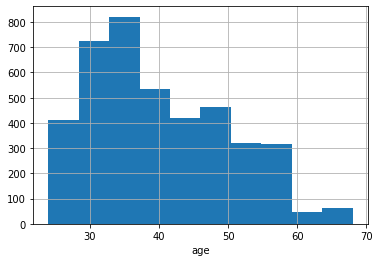

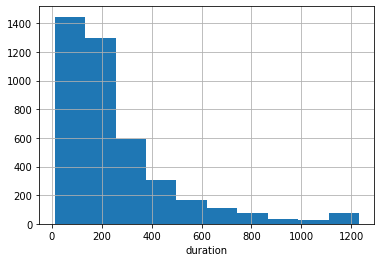

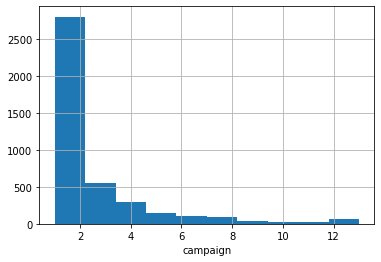

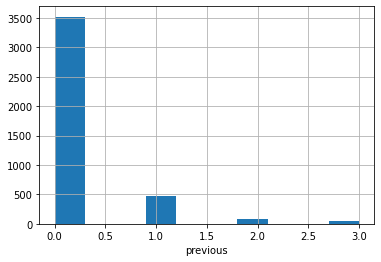

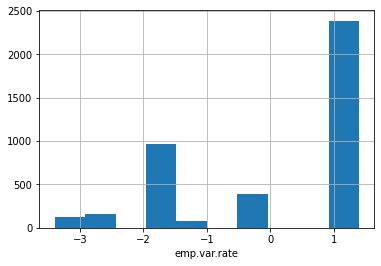

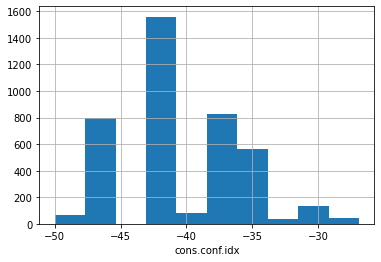

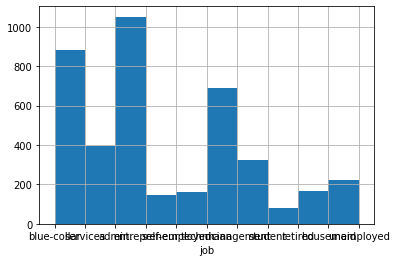

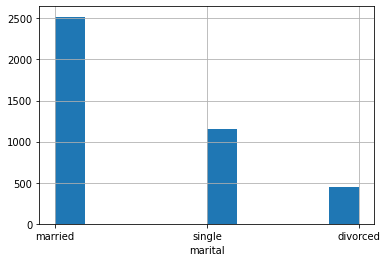

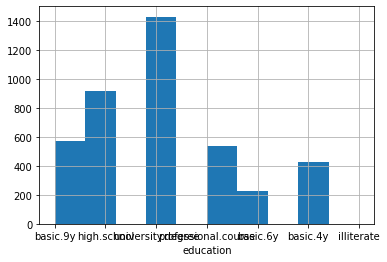

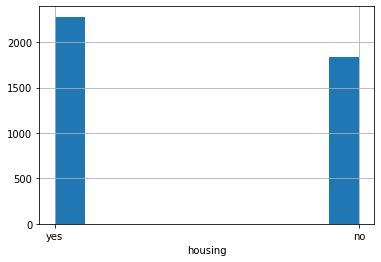

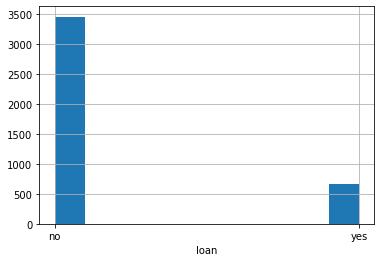

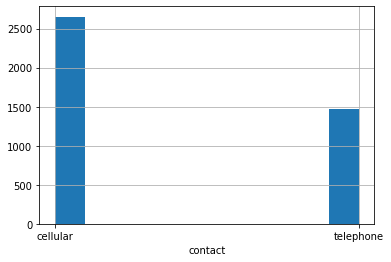

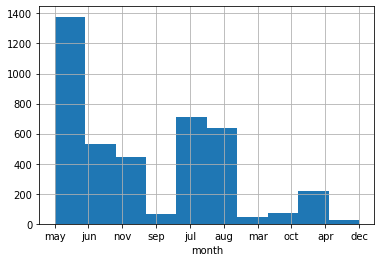

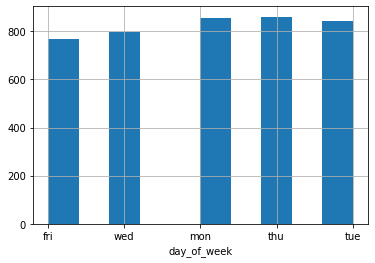

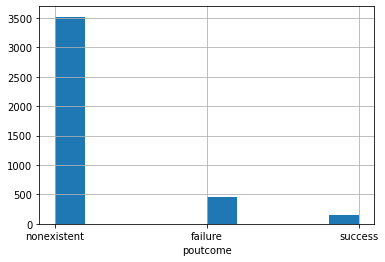

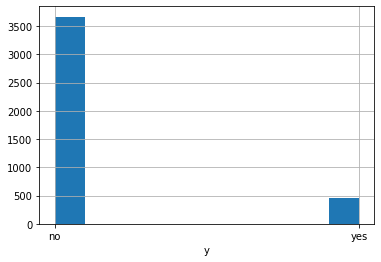

In [19]:
for i in data_final.columns:
    data_final[i].hist()
    plt.xlabel(str(i))
    plt.show()

In [20]:
data_final.y.value_counts(normalize=True)

no     0.890507
yes    0.109493
Name: y, dtype: float64

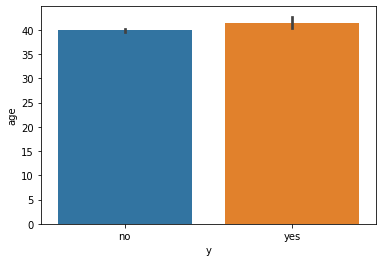

In [21]:
sns.barplot(x='y',y='age',data=data_final)
plt.show()

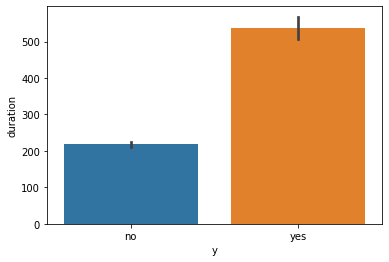

In [22]:
sns.barplot(x='y',y='duration',data=data_final)
plt.show()

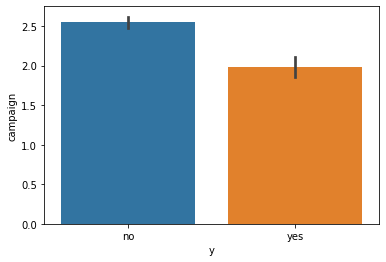

In [23]:
sns.barplot(x='y',y='campaign',data=data_final)
plt.show()

In [24]:
# Insights from above plots

# --> Usually calls duration that exceed 250 seconds consider client approval (note: if duration =0 then y = No).
# --> Average age for clients is 39.
# --> Most clients get contact 2 times in each campaign. 
# --> Most of the clients that are yes in campaign do not have loans
# --> More than 70% clients have a direct call from the bank.
# -->  90% of clients would be subscribed (Yes).

In [25]:
data_final = pd.get_dummies(data_final, columns = cat_var.columns,  drop_first=True)

In [26]:
data_final.head()

age  duration  campaign  previous  emp.var.rate  cons.conf.idx  \
0   30     487.0         2         0          -1.8          -46.2   
1   39     346.0         4         0           1.1          -36.4   
2   25     227.0         1         0           1.4          -41.8   
3   38      17.0         3         0           1.4          -41.8   
4   47      58.0         1         0          -0.1          -42.0   

   job_blue-collar  job_entrepreneur  job_housemaid  job_management  ...  \
0                1                 0              0               0  ...   
1                0                 0              0               0  ...   
2                0                 0              0               0  ...   
3                0                 0              0               0  ...   
4                0                 0              0               0  ...   

   month_nov  month_oct  month_sep  day_of_week_mon  day_of_week_thu  \
0          0          0          0                0                0   
1          0          0          0                0                0   
2          0          0          0                0                0   
3          0          0          0                0                0   
4          1          0          0                1                0   

   day_of_week_tue  day_of_week_wed  poutcome_nonexistent  poutcome_success  \
0                0                0                     1                 0   
1                0                0                     1                 0   
2                0                1                     1                 0   
3                0                0                     1                 0   
4                0                0                     1                 0   

   y_yes  
0      0  
1      0  
2      0  
3      0  
4      0  

[5 rows x 43 columns]

In [27]:
data_final.columns

Index(['age', 'duration', 'campaign', 'previous', 'emp.var.rate',
       'cons.conf.idx', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'marital_married',
       'marital_single', 'education_basic.6y', 'education_basic.9y',
       'education_high.school', 'education_illiterate',
       'education_professional.course', 'education_university.degree',
       'housing_yes', 'loan_yes', 'contact_telephone', 'month_aug',
       'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may',
       'month_nov', 'month_oct', 'month_sep', 'day_of_week_mon',
       'day_of_week_thu', 'day_of_week_tue', 'day_of_week_wed',
       'poutcome_nonexistent', 'poutcome_success', 'y_yes'],
      dtype='object')

In [28]:
data_final.columns = [i.replace('.', '_').replace('-', '_') for i in data_final.columns]

In [29]:
data_final.columns

Index(['age', 'duration', 'campaign', 'previous', 'emp_var_rate',
       'cons_conf_idx', 'job_blue_collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self_employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'marital_married',
       'marital_single', 'education_basic_6y', 'education_basic_9y',
       'education_high_school', 'education_illiterate',
       'education_professional_course', 'education_university_degree',
       'housing_yes', 'loan_yes', 'contact_telephone', 'month_aug',
       'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may',
       'month_nov', 'month_oct', 'month_sep', 'day_of_week_mon',
       'day_of_week_thu', 'day_of_week_tue', 'day_of_week_wed',
       'poutcome_nonexistent', 'poutcome_success', 'y_yes'],
      dtype='object')

### Feature Reduction

##### Weight of evidence & information value

In [30]:
def calculate_woe_iv(dataset, feature, target):
    lst = []
    
    for i in range(dataset[feature].nunique()):
        val = list(dataset[feature].unique())[i]
        lst.append({
            'Value': val,
            'All': dataset[dataset[feature] == val].count()[feature],
            'Good': dataset[(dataset[feature] == val) & (dataset[target] == 0)].count()[feature],
            'Bad': dataset[(dataset[feature] == val) & (dataset[target] == 1)].count()[feature]
        })
        
    dset = pd.DataFrame(lst)
    dset['Distr_Good'] = dset['Good'] / dset['Good'].sum()
    dset['Distr_Bad'] = dset['Bad'] / dset['Bad'].sum()
    dset['WoE'] = np.log(dset['Distr_Good'] / dset['Distr_Bad'])
    dset = dset.replace({'WoE': {np.inf: 0, -np.inf: 0}})
    dset['IV'] = (dset['Distr_Good'] - dset['Distr_Bad']) * dset['WoE']
    iv = dset['IV'].sum()
    
    dset = dset.sort_values(by='WoE')
    
    return dset, iv

In [31]:
for col in data_final.columns:
    if col == 'y_yes': continue
    else:
        print('WoE and IV for column: {}'.format(col))
        df, iv = calculate_woe_iv(data_final, col, 'y_yes')
       # print(df)
        print('IV score: {:.2f}'.format(iv))
        print('\n')

WoE and IV for column: age
IV score: 0.30


WoE and IV for column: duration
IV score: 0.76


WoE and IV for column: campaign
IV score: 0.08


WoE and IV for column: previous
IV score: 0.42


WoE and IV for column: emp_var_rate
IV score: 1.04


WoE and IV for column: cons_conf_idx
IV score: 1.34


WoE and IV for column: job_blue_collar
IV score: 0.05


WoE and IV for column: job_entrepreneur
IV score: 0.02


WoE and IV for column: job_housemaid
IV score: 0.00


WoE and IV for column: job_management
IV score: 0.00


WoE and IV for column: job_retired
IV score: 0.05


WoE and IV for column: job_self_employed
IV score: 0.00


WoE and IV for column: job_services
IV score: 0.01


WoE and IV for column: job_student
IV score: 0.02


WoE and IV for column: job_technician
IV score: 0.00


WoE and IV for column: job_unemployed
IV score: 0.01


WoE and IV for column: marital_married
IV score: 0.01


WoE and IV for column: marital_single
IV score: 0.02


WoE and IV for column: education_basic_6y
IV

In [32]:
l_iv=['age','duration','previous','emp_var_rate','cons_conf_idx','contact_telephone','month_mar','month_may','poutcome_nonexistent','poutcome_success']

-------------------------------------------------------------------------------------------------------------------------------

In [33]:
X = data_final[data_final.columns.difference(['y_yes'])]
y = data_final.y_yes

##### RFE

In [34]:
from sklearn.ensemble import RandomForestClassifier

In [35]:
rfe = RFE(RandomForestClassifier(), n_features_to_select=10).fit(X,y)

In [36]:
l2_rfe = X.columns[rfe.get_support()]

In [37]:
l2_rfe

Index(['age', 'campaign', 'cons_conf_idx', 'duration',
       'education_university_degree', 'emp_var_rate', 'housing_yes',
       'marital_married', 'poutcome_success', 'previous'],
      dtype='object')

------------------------------------------------------------------------------------------------------------------------------

##### selectKbest

In [38]:
SKB = SelectKBest(f_classif, k=10).fit(X, y )

In [39]:
l3_skb = X.columns[SKB.get_support()]

------------------------------------------------------------------------------------------------------------------------------

In [40]:
list(set((l_iv)+list(l2_rfe)+list(l3_skb)))

['month_may',
 'month_oct',
 'poutcome_nonexistent',
 'cons_conf_idx',
 'campaign',
 'month_dec',
 'month_sep',
 'contact_telephone',
 'age',
 'housing_yes',
 'marital_married',
 'duration',
 'emp_var_rate',
 'month_mar',
 'education_university_degree',
 'previous',
 'poutcome_success']

In [41]:
Final_list =['month_mar','month_may','month_sep','month_oct','month_dec',
 'emp_var_rate',
 'contact_telephone',
 'duration',
 'housing_yes',
 'campaign',
 'marital_married',
 'poutcome_success',
 'previous',
 'education_university_degree']

##### VIF check Multicollinarity

In [42]:
X_new = X[Final_list]
y = y

In [43]:
vif = pd.DataFrame()
vif["VIF_Factor"] = [variance_inflation_factor(X_new.values, i) for i in range(X_new.shape[1])]
vif["features"] = X_new.columns

In [44]:
vif.sort_values(by='VIF_Factor', ascending=False, inplace=True)
vif

VIF_Factor                     features
6     2.233773            contact_telephone
10    2.107665              marital_married
1     1.946868                    month_may
9     1.941710                     campaign
8     1.884228                  housing_yes
7     1.843997                     duration
12    1.773865                     previous
5     1.751971                 emp_var_rate
11    1.429794             poutcome_success
13    1.415659  education_university_degree
3     1.106458                    month_oct
2     1.104502                    month_sep
0     1.050760                    month_mar
4     1.045186                    month_dec

In [45]:
data_model = pd.concat([X_new, y], axis=1)

In [46]:
X_new.columns

Index(['month_mar', 'month_may', 'month_sep', 'month_oct', 'month_dec',
       'emp_var_rate', 'contact_telephone', 'duration', 'housing_yes',
       'campaign', 'marital_married', 'poutcome_success', 'previous',
       'education_university_degree'],
      dtype='object')

------------------------------------------------------------------------------------------------------------------------------

### Statstical Model

In [48]:
# split the data into train and test
train,test=train_test_split(data_model,test_size=0.3,random_state=42)

In [49]:
print('train size: ',train.shape)
print('---------------------------')
print('test size: ',test.shape)

train size:  (2883, 15)
---------------------------
test size:  (1236, 15)


In [50]:
 #Logistic Regression

import statsmodels.formula.api as smf

eqn = 'y_yes~ '+'+'.join(X_new.columns.difference(['marital_married','campaign','month_sep','housing_yes','month_dec','previous','contact_telephone']))

In [51]:
model_logit=smf.logit(eqn,data=train).fit()
print(model_logit.summary())

Optimization terminated successfully.
         Current function value: 0.201755
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  y_yes   No. Observations:                 2883
Model:                          Logit   Df Residuals:                     2875
Method:                           MLE   Df Model:                            7
Date:                Thu, 14 Apr 2022   Pseudo R-squ.:                  0.4212
Time:                        23:13:27   Log-Likelihood:                -581.66
converged:                       True   LL-Null:                       -1005.0
Covariance Type:            nonrobust   LLR p-value:                1.575e-178
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -4.4454      0.190    -23.420      0.000   

In [52]:
train_pred = model_logit.predict(train)
test_pred = model_logit.predict(test)

In [53]:
print('train_auc', metrics.roc_auc_score(train.y_yes, train_pred))
print('test_auc', metrics.roc_auc_score(test.y_yes, test_pred))
print('---------------------------------------------------------------')
print('train_gini', 2*metrics.roc_auc_score(train.y_yes, train_pred)-1)
print('test_gini', 2*metrics.roc_auc_score(test.y_yes, test_pred)-1)

train_auc 0.9360649141630901
test_auc 0.9284791544333529
---------------------------------------------------------------
train_gini 0.8721298283261802
test_gini 0.8569583088667059


###### Best Cut-off

In [54]:
train['pred_prob'] = train_pred
test['pred_prob'] = test_pred

In [55]:
# Getting highest sensitivity+specificity
roc_df = pd.DataFrame()
for cut_off in np.linspace(0,1):
  
    train['y_pred'] = np.where(train.pred_prob>cut_off, 1, 0)
    train['TP'] = np.where(((train.y_yes ==1) & (train.y_pred==1)), 1, 0)
    train['TN'] = np.where(((train.y_yes ==0) & (train.y_pred==0)), 1, 0)
    train['FP'] = np.where(((train.y_yes ==0) & (train.y_pred==1)), 1, 0)
    train['FN'] = np.where(((train.y_yes ==1) & (train.y_pred==0)), 1, 0)
    sensitivity = train.TP.sum()/train.y_yes.sum()
    specificity = train.TN.sum()/(1-train.y_yes).sum()
    accuracy = (train.TN.sum()+train.TP.sum())/train.y_yes.count()
    roc_like_table = pd.DataFrame([cut_off, sensitivity, specificity, accuracy]).T
    roc_like_table.columns = ['cutoff', 'sensitivity', 'specificity', 'accuracy']
    roc_df = pd.concat([roc_df, roc_like_table], axis=0)

In [56]:
roc_df['Total'] = roc_df.sensitivity+roc_df.specificity

In [57]:
best_cutoff = roc_df.sort_values(by='Total', ascending=False).head(1).cutoff[0]
print('Best_cutoff: ', best_cutoff)

Best_cutoff:  0.12244897959183673


In [58]:
train['y_pred'] = np.where(train.pred_prob>best_cutoff, 1,0)
test['y_pred'] = np.where(test.pred_prob>best_cutoff, 1,0)

In [59]:
print('train_auc', metrics.roc_auc_score(train.y_yes, train.y_pred))
print('test_auc', metrics.roc_auc_score(test.y_yes, test.y_pred))

train_auc 0.8721523849005072
test_auc 0.8601982660357156


In [60]:
print(metrics.classification_report(train.y_yes, train.y_pred))

              precision    recall  f1-score   support

           0       0.98      0.86      0.92      2563
           1       0.44      0.88      0.59       320

    accuracy                           0.86      2883
   macro avg       0.71      0.87      0.75      2883
weighted avg       0.92      0.86      0.88      2883



In [61]:
print(metrics.classification_report(test.y_yes, test.y_pred))

              precision    recall  f1-score   support

           0       0.98      0.84      0.91      1105
           1       0.40      0.88      0.55       131

    accuracy                           0.85      1236
   macro avg       0.69      0.86      0.73      1236
weighted avg       0.92      0.85      0.87      1236



In [62]:
# Getting the target clients to get the direct call from the Bank.
# starting with the top 100 customers.
top_100cust_for_targeting = test.sort_values(by='pred_prob', ascending=False).head(100)

In [63]:
top_100cust_for_targeting

month_mar  month_may  month_sep  month_oct  month_dec  emp_var_rate  \
3580          0          0          0          0          0          -1.7   
3998          1          0          0          0          0          -1.8   
2542          0          0          0          0          0          -1.8   
288           0          0          0          0          0          -1.7   
3364          1          0          0          0          0          -1.8   
...         ...        ...        ...        ...        ...           ...   
251           0          0          1          0          0          -3.4   
1260          0          1          0          0          0          -1.8   
3161          0          0          1          0          0          -3.4   
2578          0          0          0          0          1          -3.0   
3661          0          0          0          0          0          -0.1   

      contact_telephone  duration  housing_yes  campaign  marital_married  \
3580                  1    1087.0            0         1                0   
3998                  0     881.0            1         3                1   
2542                  0    1203.0            0         2                1   
288                   0    1207.0            0         4                1   
3364                  1     450.0            0         3                0   
...                 ...       ...          ...       ...              ...   
251                   0     355.0            1         1                1   
1260                  0     754.0            1         2                1   
3161                  0     351.0            0         2                0   
2578                  0     391.0            1         2                1   
3661                  0     690.0            1         1                1   

      poutcome_success  previous  education_university_degree  y_yes  \
3580                 1         1                            1      1   
3998                 0         1                            0      1   
2542                 0         1                            0      1   
288                  0         1                            0      1   
3364                 1         2                            0      1   
...                ...       ...                          ...    ...   
251                  0         0                            1      0   
1260                 0         2                            0      0   
3161                 0         0                            1      0   
2578                 0         0                            1      1   
3661                 0         0                            1      0   

      pred_prob  y_pred  
3580   0.994854       1  
3998   0.973486       1  
2542   0.972987       1  
288    0.971996       1  
3364   0.962763       1  
...         ...     ...  
251    0.480346       1  
1260   0.475806       1  
3161   0.474583       1  
2578   0.472202       1  
3661   0.467896       1  

[100 rows x 17 columns]

-------------------------------------------------------------------------------------------------------------------------------

## ML ALGOS

In [64]:
train_X, test_X, train_y, test_y = train_test_split(X_new, y, test_size=0.3, random_state=123)

### KNN

In [66]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

In [67]:
sc=StandardScaler()
sc = sc.fit(train_X)

In [68]:
train_X_std=sc.transform(train_X)

In [69]:
test_X_std=sc.transform(test_X)

In [70]:
knn_param = {'n_neighbors':[7,8,9,10,11,12,13], 'weights':['uniform', 'distance']}

knn_model = GridSearchCV(KNeighborsClassifier(), knn_param, cv=5, scoring='roc_auc', n_jobs=-1, verbose=True).fit(train_X_std, train_y)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    5.8s finished


In [71]:
knn_model.best_params_

{'n_neighbors': 13, 'weights': 'uniform'}

In [72]:
knn_model.best_score_

0.8937336886744365

In [73]:
knn_model_final = KNeighborsClassifier(n_neighbors=10, weights='uniform', n_jobs=-1).fit(train_X_std, train_y)

In [74]:
train_pred_prob= np.where(pd.DataFrame(knn_model_final.predict_proba(train_X_std))[1]>0.122, 1, 0)
test_pred_prob = np.where(pd.DataFrame(knn_model_final.predict_proba(test_X_std))[1]>0.122, 1, 0)

In [75]:
print('ROC_AUC_Train:', metrics.roc_auc_score(train_y, train_pred_prob))
print('--------------------------------------------------------------------')
print('ROC_AUC_Test:', metrics.roc_auc_score(test_y, test_pred_prob))

ROC_AUC_Train: 0.8901504997268699
--------------------------------------------------------------------
ROC_AUC_Test: 0.7993742368742369


In [76]:
print(metrics.classification_report(train_y, knn_model_final.predict(train_X)))

              precision    recall  f1-score   support

           0       0.95      0.41      0.58      2576
           1       0.14      0.81      0.24       307

    accuracy                           0.46      2883
   macro avg       0.55      0.61      0.41      2883
weighted avg       0.86      0.46      0.54      2883



In [77]:
print(metrics.classification_report(test_y, knn_model_final.predict(test_X)))

              precision    recall  f1-score   support

           0       0.93      0.38      0.54      1092
           1       0.14      0.78      0.24       144

    accuracy                           0.43      1236
   macro avg       0.54      0.58      0.39      1236
weighted avg       0.84      0.43      0.50      1236



-------------------------------------------------------------------------------------------------------------------------------

### DT

In [78]:
from sklearn.tree import DecisionTreeClassifier

In [79]:
dt_param= {'max_depth': np.arange(3, 7),'max_features': np.arange(3,13)}

In [80]:
dt_model = GridSearchCV(DecisionTreeClassifier(), dt_param, cv = 5,scoring='roc_auc', n_jobs=-1, verbose=True).fit( train_X, train_y )

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 190 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.8s finished


In [81]:
dt_model.best_params_

{'max_depth': 6, 'max_features': 7}

In [82]:
dt_model.best_score_

0.8934671325001393

In [83]:
dt_model_final = DecisionTreeClassifier(max_features=7,max_depth=6, random_state=42).fit(train_X, train_y)

In [84]:
train_pred = np.where(pd.DataFrame(dt_model_final.predict_proba(train_X))[1]>0.122, 1, 0)
test_pred = np.where(pd.DataFrame(dt_model_final.predict_proba(test_X))[1]>0.122, 1, 0)

In [85]:
print('ROC_AUC_Train: ', metrics.roc_auc_score(train_y, train_pred))
print('--------------------------------------------------------------------')
print('ROC_AUC_Test: ', metrics.roc_auc_score(test_y, test_pred))

ROC_AUC_Train:  0.886293169725049
--------------------------------------------------------------------
ROC_AUC_Test:  0.8080357142857143


In [86]:
print(metrics.classification_report(train_y, dt_model_final.predict(train_X)))

              precision    recall  f1-score   support

           0       0.94      0.97      0.96      2576
           1       0.69      0.48      0.56       307

    accuracy                           0.92      2883
   macro avg       0.82      0.73      0.76      2883
weighted avg       0.91      0.92      0.92      2883



In [87]:
print(metrics.classification_report(test_y, dt_model_final.predict(test_X)))

              precision    recall  f1-score   support

           0       0.92      0.97      0.94      1092
           1       0.59      0.38      0.46       144

    accuracy                           0.90      1236
   macro avg       0.76      0.67      0.70      1236
weighted avg       0.88      0.90      0.89      1236



In [88]:
import graphviz
from sklearn import tree

In [89]:
fig=plt.figure(figsize=(100,60))


<Figure size 7200x4320 with 0 Axes>

In [90]:
columns=list(train_X.columns)

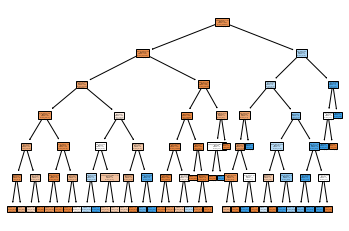

In [91]:
_=tree.plot_tree(dt_model_final,feature_names=columns,class_names=True,filled=True)
fig.savefig('bank_tree.png')


------------------------------------------------------------------------------------------------------------------------------

### RF

In [92]:
from sklearn.ensemble import RandomForestClassifier

In [98]:
RandomForestClassifier?

In [93]:
rf_param={'n_estimators':[50,100,150,200],'max_depth':[6,7,8,9,10,11,12,13],'max_features':[4,5,6,7,8,9]}
rf_model = GridSearchCV(RandomForestClassifier(), rf_param, cv=5, scoring='roc_auc',n_jobs=-1,verbose=True).fit(train_X,train_y)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed:  2.8min finished


In [94]:
rf_model.best_params_

{'max_depth': 8, 'max_features': 5, 'n_estimators': 150}

In [95]:
rf_model.best_score_

0.9352838641380862

In [96]:
rf_model_final = RandomForestClassifier(n_estimators=150, max_features=5,max_depth=8, n_jobs=-1, random_state=45).fit(train_X, train_y)

In [97]:
train_pred = (pd.DataFrame(rf_model_final.predict_proba(train_X))[1])
test_pred =(pd.DataFrame(rf_model_final.predict_proba(test_X))[1])

In [98]:
print('ROC_AUC_Train: ', metrics.roc_auc_score(train_y, train_pred))
print('--------------------------------------------------------------------')
print('ROC_AUC_Test: ', metrics.roc_auc_score(test_y, test_pred))

ROC_AUC_Train:  0.9794539168875311
--------------------------------------------------------------------
ROC_AUC_Test:  0.9354586385836385


In [99]:
print(metrics.classification_report(train_y, rf_model_final.predict(train_X)))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      2576
           1       0.93      0.59      0.72       307

    accuracy                           0.95      2883
   macro avg       0.94      0.79      0.85      2883
weighted avg       0.95      0.95      0.95      2883



In [100]:
print(metrics.classification_report(test_y, rf_model_final.predict(test_X)))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1092
           1       0.69      0.38      0.49       144

    accuracy                           0.91      1236
   macro avg       0.81      0.68      0.72      1236
weighted avg       0.90      0.91      0.90      1236



-------------------------------------------------------------------------------------------------------------------------------

### XGBoost

In [101]:
import xgboost

In [102]:
from xgboost import XGBClassifier

In [109]:
XGBClassifier?

In [103]:
param_xgb={ 'learning_rate':[0.01,0.1,0.15,0.2],'n_estimators':[30,50,100],'max_depth':[3,4,5],'gamma':[0.01,0.05,0.1,1],'subsample':[0.7,0.8,0.9]}
xgb_model=GridSearchCV(XGBClassifier(),param_xgb,cv=5,n_jobs=-1,scoring='roc_auc',verbose=True).fit(train_X,train_y)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   53.6s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed:  2.6min finished


In [104]:
xgb_model.best_params_

{'gamma': 0.05,
 'learning_rate': 0.15,
 'max_depth': 3,
 'n_estimators': 50,
 'subsample': 0.7}

In [105]:
xgb_model.best_score_

0.9342344499064446

In [106]:
xgb_model_final = XGBClassifier( learning_rate=0.15,n_estimators=50,max_depth=3,gamma=0.05,subsample=0.7
                                ,n_jobs=-1,random_state=12345).fit(train_X, train_y)

In [107]:
train_pred = (pd.DataFrame(xgb_model_final.predict_proba(train_X))[1])
test_pred = (pd.DataFrame(xgb_model_final.predict_proba(test_X))[1])

In [108]:
print('ROC_AUC_Train: ', metrics.roc_auc_score(train_y, train_pred))
print('--------------------------------------------------------------------')
print('ROC_AUC_Test: ', metrics.roc_auc_score(test_y, test_pred))

ROC_AUC_Train:  0.9543714720699212
--------------------------------------------------------------------
ROC_AUC_Test:  0.9299068986568986


In [109]:
print(metrics.classification_report(train_y, xgb_model_final.predict(train_X)))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96      2576
           1       0.72      0.50      0.59       307

    accuracy                           0.93      2883
   macro avg       0.83      0.74      0.78      2883
weighted avg       0.92      0.93      0.92      2883



In [110]:
print(metrics.classification_report(test_y, xgb_model_final.predict(test_X)))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      1092
           1       0.67      0.47      0.55       144

    accuracy                           0.91      1236
   macro avg       0.80      0.72      0.75      1236
weighted avg       0.90      0.91      0.90      1236



-------------------------------------------------------------------------------------------------------------------------------

###### Best ML ALGO is XGBoost so it will be use for our Model.

-------------------------------------------------------------------------------------------------------------------------------

In [130]:
xgb_model_final.predict(test_X.iloc[0:100],validate_features=False)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], dtype=uint8)

# Saving the Model

In [131]:
import joblib

In [132]:
model=joblib.dump(xgb_model_final,'model_xgb.h5')